In [1]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
from dgl.data.utils import load_graphs
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Using backend: pytorch


In [2]:
data = pd.read_csv('./bot.csv')

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (7,9) have mixed types. Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
data.drop(columns=['subcategory','pkSeqID','stime','flgs','attack','state','proto','seq'],inplace=True)

In [4]:
data.rename(columns={"category": "label"},inplace = True)

In [5]:
data.label.value_counts()

DDoS              1926624
DoS               1650260
Reconnaissance      91082
Normal                477
Theft                  79
Name: label, dtype: int64

In [6]:
DDoS = data[data['label'] == 'DDoS'].sample(frac=0.1)
DoS = data[data['label'] == 'DoS'].sample(frac=0.1)
Reconnaissance = data[data['label'] == 'Reconnaissance'].sample(frac=0.1)
Normal = data[data['label'] == 'Normal']
Theft = data[data['label'] == 'Theft']

In [7]:
data = pd.concat([DDoS,DoS,Reconnaissance,Normal,Theft])

In [8]:
data.label.value_counts()

DDoS              192662
DoS               165026
Reconnaissance      9108
Normal               477
Theft                 79
Name: label, dtype: int64

In [9]:
le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])

In [10]:
data['saddr'] = data.saddr.apply(str)
data['sport'] = data.sport.apply(str)
data['daddr'] = data.daddr.apply(str)
data['dport'] = data.dport.apply(str)

In [11]:
data['saddr'] = data.saddr.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [12]:
data['saddr'] = data['saddr'] + ':' + data['sport']
data['daddr'] = data['daddr'] + ':' + data['dport']

In [13]:
data.drop(columns=['sport','dport'],inplace=True)
label_ground_truth = data[["saddr", "daddr","label"]]
data = pd.get_dummies(data, columns = ['flgs_number','state_number', 'proto_number'])

In [14]:
data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan,inplace = True)

In [15]:
data.fillna(0,inplace = True)

In [16]:
label_ground_truth = data[["saddr", "daddr","label"]]

In [17]:
data.drop(columns=['index'],inplace=True)

In [18]:
data

,saddr,daddr,pkts,bytes,ltime,dur,mean,stddev,sum,min,...,state_number_6,state_number_7,state_number_8,state_number_9,state_number_10,proto_number_1,proto_number_2,proto_number_3,proto_number_4,proto_number_5
0,172.19.185.130:45902,192.168.100.3:80,5,582,1.528096e+09,28.429037,0.058227,0.082346,0.174682,0.000000,...,0,0,0,0,0,1,0,0,0,0
1,172.22.45.9:55078,192.168.100.3:80,14,840,1.528099e+09,13.669207,3.906063,1.371369,11.718190,1.966672,...,0,0,0,0,0,0,0,1,0,0
2,172.21.140.85:24097,192.168.100.3:80,9,1010,1.528096e+09,39.042847,0.091569,0.113802,0.457844,0.000000,...,0,0,0,0,0,1,0,0,0,0
3,172.28.31.207:10231,192.168.100.3:80,8,480,1.528099e+09,14.288983,3.413249,0.925521,10.239748,2.104366,...,0,0,0,0,0,0,0,1,0,0
4,172.29.230.186:58406,192.168.100.3:80,5,770,1.528096e+09,12.178850,1.969910,1.393350,5.909730,0.000000,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367347,172.27.22.181:35064,192.168.100.3:22,6,434,1.529381e+09,0.013165,0.013165,0.000000,0.013165,0.013165,...,0,0,0,0,0,1,0,0,0,0
367348,172.22.211.43:35066,192.168.100.3:22,6,434,1.529381e+09,0.000574,0.000574,0.000000,0.000574,0.000574,...,0,0,0,0,0,1,0,0,0,0
367349,172.29.30.209:35070,192.168.100.3:22,31,5472,1.529381e+09,2.874302,2.874302,0.000000,2.874302,2.874302,...,1,0,0,0,0,1,0,0,0,0
367350,172.29.82.94:43001,192.168.100.150:4433,2,134,1.529381e+09,0.000003,0.000003,0.000000,0.000003,0.000003,...,0,0,0,0,0,1,0,0,0,0


In [19]:
scaler = StandardScaler()
cols_to_norm = list(set(list(data.iloc[:, 2:].columns ))  - set(list(['label'])) )
data[cols_to_norm] = scaler.fit_transform(data[cols_to_norm])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label_ground_truth, test_size=0.3, random_state=42, stratify=label_ground_truth.label)

In [21]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

<ipython-input-21-841b8327893c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['h'] = X_train[ cols_to_norm ].values.tolist()


In [22]:
#from dgl.data.utils import load_graphs   
#G = load_graphs("./data.bin")[0][0]

In [23]:
G = nx.from_pandas_edgelist(X_train, "saddr", "daddr", ['h','label'], create_using= nx.MultiGraph())

In [24]:
G = G.to_directed()

In [25]:
G = from_networkx(G,edge_attrs=['h','label'])

In [26]:
#from dgl.data.utils import save_graphs
#save_graphs("./data.bin", [G])


In [27]:
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1]) 

In [28]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype= th.bool)

In [29]:
#G = load_graphs("./bot_train_G.bin") [0][0]

In [30]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [31]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)

In [32]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1, G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1, G.edata['h'].shape[1]))

In [33]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        global score
        global emb
        emb = th.cat([h_u, h_v], 1)
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [34]:
G.ndata['h'].shape

torch.Size([261166, 1, 52])

In [35]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [36]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [37]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 5)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [38]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(G.edata['label'].cpu().numpy()),
                                                 G.edata['label'].cpu().numpy())

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4], y=[1 1 0 ... 1 1 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [39]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

In [40]:
G = G.to('cuda:0')

In [41]:
G.device

device(type='cuda', index=0)

In [42]:
G.ndata['h'].device  

device(type='cuda', index=0)

In [43]:
G.edata['h'].device  

device(type='cuda', index=0)

In [44]:
criterion = nn.CrossEntropyLoss()

In [45]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()

opt = th.optim.Adam(model.parameters())

for epoch in range(1,8000):
    pred = model(G, node_features,edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print('Epoch:', epoch ,' Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

Epoch: 100  Training acc: 0.9641274213790894
Epoch: 200  Training acc: 0.9846566319465637
Epoch: 300  Training acc: 0.985148549079895
Epoch: 400  Training acc: 0.9922340512275696
Epoch: 500  Training acc: 0.9932879209518433
Epoch: 600  Training acc: 0.9939004182815552
Epoch: 700  Training acc: 0.9916993379592896
Epoch: 800  Training acc: 0.9930273294448853
Epoch: 900  Training acc: 0.9956056475639343
Epoch: 1000  Training acc: 0.9952245354652405
Epoch: 1100  Training acc: 0.9982675909996033
Epoch: 1200  Training acc: 0.997205913066864
Epoch: 1300  Training acc: 0.9964048266410828
Epoch: 1400  Training acc: 0.9990414381027222
Epoch: 1500  Training acc: 0.9983706474304199
Epoch: 1600  Training acc: 0.997876763343811
Epoch: 1700  Training acc: 0.9987595081329346
Epoch: 1800  Training acc: 0.9991114735603333
Epoch: 1900  Training acc: 0.9992961883544922
Epoch: 2000  Training acc: 0.9992417097091675
Epoch: 2100  Training acc: 0.9992786645889282
Epoch: 2200  Training acc: 0.9993525743484497


KeyboardInterrupt: 

In [46]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

<ipython-input-46-84be06ca8888>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['h'] = X_test[ cols_to_norm ].values.tolist()


In [47]:
#G_test = load_graphs("bot_test_G.bin") [0][0]
G_test = nx.from_pandas_edgelist(X_test, "saddr", "daddr", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')


In [48]:
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), 52)

In [49]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [50]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))

In [51]:
G_test = G_test.to('cuda:0')

In [52]:
th.cuda.empty_cache()

In [53]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [54]:
print(str(elapsed) + ' seconds')

0.02142857900071249 seconds


In [55]:
test_pred = test_pred.argmax(1)

In [56]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

In [57]:
edge_label = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)

In [58]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

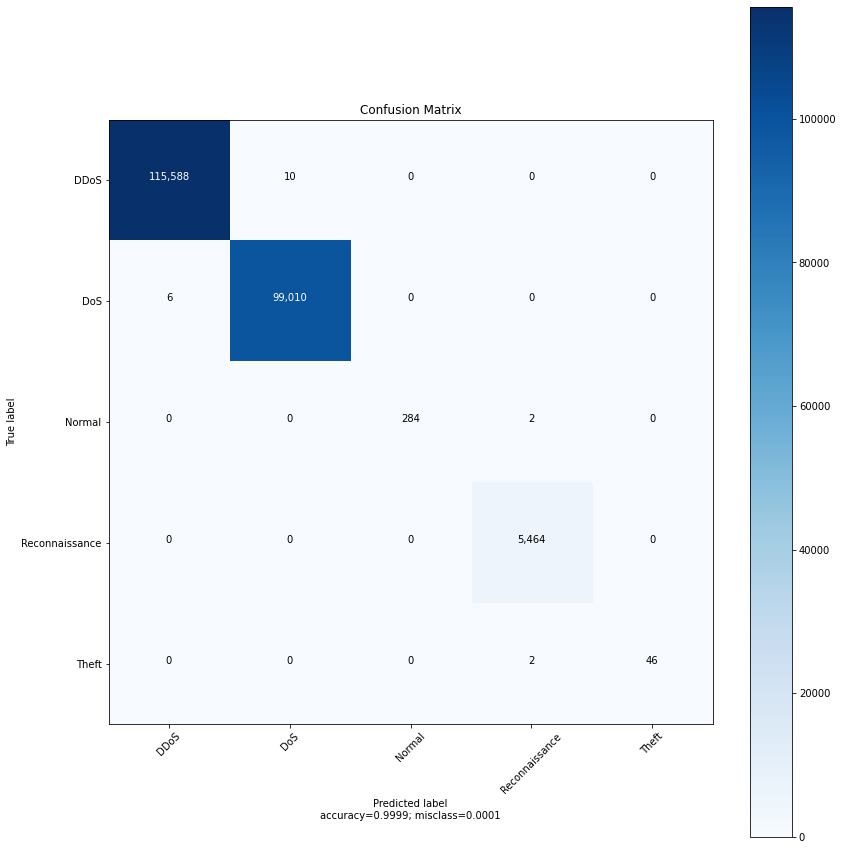

In [59]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(edge_label, test_pred), 
                      normalize    = False,
                      target_names = np.unique(edge_label),
                      title        = "Confusion Matrix")

In [60]:
from sklearn.metrics import classification_report
target_names = np.unique(edge_label)
print(classification_report(edge_label, test_pred, target_names=target_names, digits=4))

                precision    recall  f1-score   support

          DDoS     0.9999    0.9999    0.9999    115598
           DoS     0.9999    0.9999    0.9999     99016
        Normal     1.0000    0.9930    0.9965       286
Reconnaissance     0.9993    1.0000    0.9996      5464
         Theft     1.0000    0.9583    0.9787        48

      accuracy                         0.9999    220412
     macro avg     0.9998    0.9902    0.9949    220412
  weighted avg     0.9999    0.9999    0.9999    220412



In [107]:
emb_num = emb.cpu().detach().numpy()

In [108]:
np.save('emb_mul.npy',emb_num)

In [109]:
emb_viz = np.load('emb_viz.npy')

In [110]:
df_umap = pd.DataFrame(emb_viz, columns=['comp1', 'comp2'])


In [111]:
df_umap['label'] = edge_label


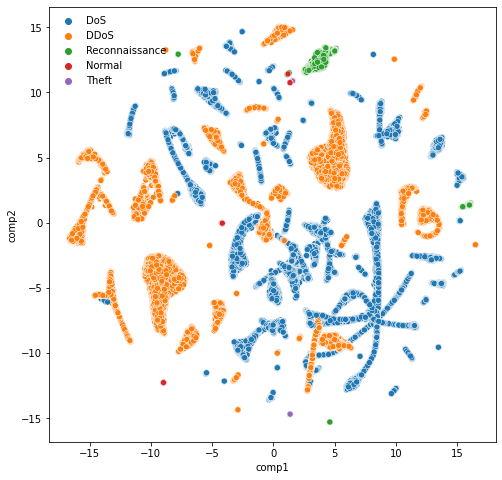

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt 

plt.figure(figsize=(8,8));
sns.scatterplot(x='comp1', y='comp2', data=df_umap, hue='label');
plt.legend(loc='upper left', frameon=False)

In [77]:
emb_num = score.cpu().detach().numpy()

In [78]:
np.save('emb_mul.npy',emb_num)

In [93]:
emb_viz = np.load('emb_viz.npy')
df_umap = pd.DataFrame(emb_viz, columns=['comp1', 'comp2'])
df_umap['label'] = edge_label


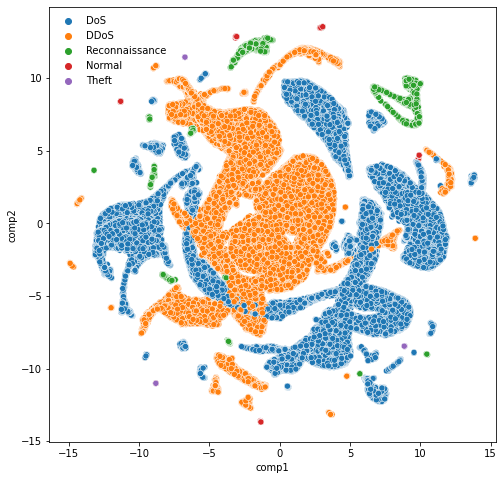

In [95]:
plt.figure(figsize=(8,8));
sns.scatterplot(x='comp1', y='comp2', data=df_umap, hue='label');
plt.legend(loc='upper left', frameon=False)

In [81]:
np.save('raw.npy',X_test.drop(columns=['saddr','daddr','h']).to_numpy())

In [96]:
raw_viz = np.load('raw.npy')

In [97]:
df_umap = pd.DataFrame(raw_viz, columns=['comp1', 'comp2'])

In [98]:
df_umap['label'] = le.inverse_transform(y_test.label)

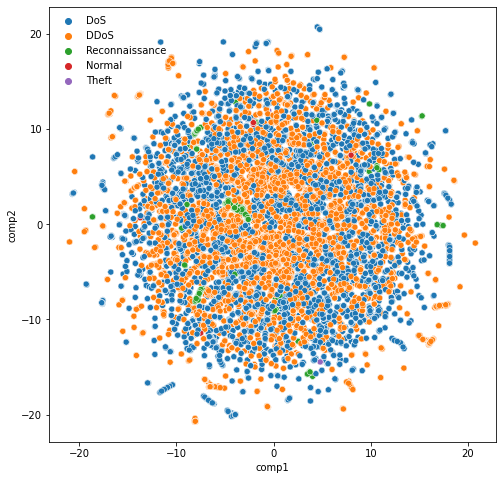

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt 

plt.figure(figsize=(8,8));
sns.scatterplot(x='comp1', y='comp2', data=df_umap, hue='label');
plt.legend(loc='upper left', frameon=False)